# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

In [3]:
PATH = "./data/"

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [5]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

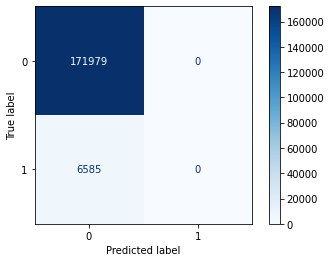

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

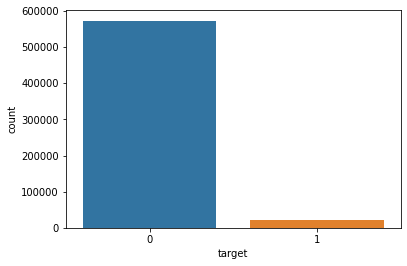

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [17]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float64)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

AUC (Area under the curve) is Square of figure under the curve defined by function TPR(FPR). So, AUC expressed through integral (wich is exectly an area under the curve of some function in some interval of its argument) looks like:

$AUC = \int_0^1TPR\partial FPR = \int_0^1\frac{TP}{c_1}\partial\frac{FP}{c_0} = \frac{1}{c_1 * c_0}\int_0^1TP\partial FP$

If we express Gini index formula through the curve in TPR-FPR space, we get  

$AUC_{Gini} = \int_0^1TPR\partial\frac{TP + FP}{c_1 + c_0} - 0.5$,  

which is 0.5 for $Gini_{perfect}$:  

$Gini_{perf} = \int_0^11 - 0.5$  (because perfect algo predicts 1.0 True Positive Rate)

So, if we substitute $Gini_{mod}$ and $Gini_{perf}$ by $AUC_{Gini}$ and 0.5, respectively:

$Gini_{norm} = \frac{Gini_{mod}}{Gini_{perf}} = \frac{\int_0^1TPR\partial\frac{TP + FP}{c_1 + c_0} - 0.5}{0.5} = 2 * (\int_0^1TPR\partial\frac{TP + FP}{c_1 + c_0} - 0.5)$

Integral part is exactly what AUC is from the 1st formula, so we get

$2 * \int_0^1TPR\partial\frac{TP + FP}{c_1 + c_0} - 1 = 2 * AUC - 1$  

which is what we are looking for.

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

I would suggest **Precision** metric, as maximizing precision means *minimizing false positive* predictions, e.g. minimizing the quantity of 'good' drivers being blamed by algorithm to be 'bad'. Such clients after recieving unfair huge bill for their insurance policy will very likely leave.

Let's calculate the Normalized Gini Coefficient:

In [15]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [18]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

#### Disclaimer:
I tried some data engineering, such as *dropping and filling NaN values* (we know that values of -1 in this dataset are actually missing), also *dropping features with low correlation with target* and *over-/undersampling*. But surprisingly, the best score I achieved was the one **WITHOUT** any feature engineering (even without missing data dealing) but with ***under- and oversampling combined with feature selection by SelectFromModel***. So this very variant is presented below. 

In [19]:
SEED = 18

In [20]:
# load test data

test_data = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [40]:
def over_under_sampling(data):
    """Helper function for over- and undersampling."""
    dominant_class_data = data[data['target'] == 0]
    underbalanced_class_data = data[data['target'] == 1]
    
    mid = int((len(dominant_class_data) + len(underbalanced_class_data)) * 0.5)
    
    underbalanced_over = underbalanced_class_data.sample(mid, replace=True)
    dominant_under = dominant_class_data.sample(mid)
    
    data_under = pd.concat([underbalanced_over, dominant_under])
    
    return data_under

In [22]:
# perform resampling

train_data_under = over_under_sampling(insurance_data)

In [23]:
# check the results - now we have dataset balanced with surrogate data

train_data_under['target'].value_counts()

0    297606
1    297606
Name: target, dtype: int64

In [24]:
# splitting

X = train_data_under.drop(columns=['target'])
y = train_data_under['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [25]:
# preprocessing, selection and classification steps of the pipeline definition

numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', SelectFromModel(SGDClassifier(loss='log', penalty='l1', n_jobs=-1, random_state=SEED))),
                           ('classifier', SGDClassifier(loss='log', n_jobs=-1, random_state=SEED))])

In [26]:
param_grid = {'classifier__alpha': [0.001, 0.01, 0.1, 0.3], 'classifier__penalty': ['l1', 'l2']}
clf = GridSearchCV(pipeline, param_grid, n_jobs=-1)

In [27]:
# fitting the model on the train subset

clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ps_ind_01',
                                                                          'ps_ind_03',
                                                                          'ps_ind_14',
                                                                          'ps_ind_15',
                                                                          'ps_reg_01',
                                                                          'ps_reg_02',
                                                                          'ps_reg_03',
                                            

In [28]:
# evaluating it

clf.best_score_

0.5947706528309374

In [29]:
clf.best_params_

{'classifier__alpha': 0.001, 'classifier__penalty': 'l2'}

In [30]:
accuracy_score(y_val, clf.predict(X_val))

0.595170359086938

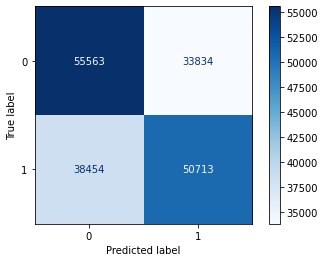

In [31]:
disp = plot_confusion_matrix(clf, X_val, y_val,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [32]:
y_pred_prob = clf.predict_proba(X_val)[:, 1]
y_pred = clf.predict(X_val)

In [33]:
precision_score(y_val, y_pred)

0.5998202183400949

In [34]:
gini_normalized(y_val, y_pred_prob)

0.2675995297826947

In [35]:
clf.best_estimator_.named_steps['classifier'].coef_

array([[ 0.09816736, -0.1293215 ,  0.07571336,  0.0509677 ,  0.08218624,
        -0.00094461,  0.05643731,  0.16379528,  0.05390975,  0.01718125,
         0.15586546, -0.04326041,  0.09551762, -0.06908093, -0.06562371,
         0.403688  , -0.41280596, -0.11572048,  0.28113833, -0.16154899,
         0.06305799,  0.23114389,  0.22030035,  0.18893095,  0.18163714,
         0.10618667,  0.26121336,  0.07837228,  0.06065745,  0.07388288,
        -0.10304155, -0.1100952 , -0.27982673,  0.10422995, -0.05096505,
        -0.13024636,  0.02324298, -0.15667711,  0.07899999,  0.04513539,
        -0.05587532,  0.24313628, -0.03078626, -0.13949735,  0.0706576 ,
        -0.04870682,  0.02292684, -0.09198883, -0.05287145,  0.08288232,
        -0.06281718,  0.13033435,  0.15149823, -0.06579333,  0.22736025,
        -0.17481669,  0.12107779, -0.06351658,  0.06727836, -0.13643085,
        -0.18610023, -0.08462595, -0.10768598, -0.10246039,  0.08078361,
         0.13198215,  0.16668773,  0.10297   , -0.1

In [36]:
# re-fit on the whole training data

clf.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ps_ind_01',
                                                                          'ps_ind_03',
                                                                          'ps_ind_14',
                                                                          'ps_ind_15',
                                                                          'ps_reg_01',
                                                                          'ps_reg_02',
                                                                          'ps_reg_03',
                                            

### TEST DATA

In [37]:
# make predictions and upload results to Kaggle

target_pred_proba = clf.predict_proba(test_data)[:, 1]

In [38]:
submit_df = pd.DataFrame({'target': target_pred_proba}, index=test_data.index)
submit_df.mean()

target    0.469001
dtype: float64

In [39]:
submit_df.to_csv(path_or_buf=os.path.join(PATH, 'porto', 'porto_submit.csv'))

Kaggle nick: Andrei Drabkin  
Best score: 0.26634  
screenshot is also on GitHub

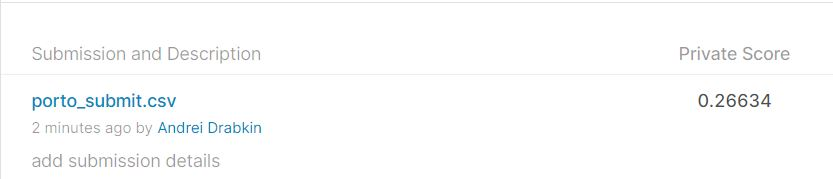